<a href="https://colab.research.google.com/github/Fatehbs/AI-applications/blob/main/Boxplot_Monte_Carlo_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np

In [ ]:
niftybees = yf.Ticker("NIFTYBEES.BO")
goldbees = yf.Ticker("GOLDBEES.BO")

In [ ]:
nifty_price = niftybees.history(period="1y")

In [ ]:
gold_price = goldbees.history(period = "1y")

In [ ]:
close_price_df = pd.DataFrame({
    'nifty_bees' : nifty_price['Close'],
    'gold_bees' : gold_price['Close']
})

In [ ]:
analyze_df = close_price_df.join(close_price_df.shift(1), rsuffix= '_prev').dropna()

In [ ]:
analyze_df.eval('r_nifty_bees = log(nifty_bees) - log(nifty_bees_prev)', inplace = True)
analyze_df.eval('r_gold_bees = log(gold_bees) - log(gold_bees_prev)', inplace = True)

In [ ]:
analyze_df

,nifty_bees,gold_bees,nifty_bees_prev,gold_bees_prev,r_nifty_bees,r_gold_bees
Date,,,,,,
2023-12-05 00:00:00+05:30,230.000000,52.919998,228.399994,53.860001,0.006981,-0.017607
2023-12-06 00:00:00+05:30,230.940002,52.860001,230.000000,52.919998,0.004079,-0.001134
2023-12-07 00:00:00+05:30,230.759995,53.020000,230.940002,52.860001,-0.000780,0.003022
2023-12-08 00:00:00+05:30,231.179993,52.950001,230.759995,53.020000,0.001818,-0.001321
2023-12-11 00:00:00+05:30,231.649994,52.049999,231.179993,52.950001,0.002031,-0.017143
...,...,...,...,...,...,...
2024-11-28 00:00:00+05:30,267.809998,64.019997,271.920013,63.959999,-0.015230,0.000938
2024-11-29 00:00:00+05:30,269.809998,64.290001,267.809998,64.019997,0.007440,0.004209
2024-12-02 00:00:00+05:30,271.450012,63.820000,269.809998,64.290001,0.006060,-0.007337


In [ ]:
rate_df = analyze_df[['r_nifty_bees', 'r_gold_bees']]

In [ ]:
rate_df

,r_nifty_bees,r_gold_bees
Date,,
2023-12-05 00:00:00+05:30,0.006981,-0.017607
2023-12-06 00:00:00+05:30,0.004079,-0.001134
2023-12-07 00:00:00+05:30,-0.000780,0.003022
2023-12-08 00:00:00+05:30,0.001818,-0.001321
2023-12-11 00:00:00+05:30,0.002031,-0.017143
...,...,...
2024-11-28 00:00:00+05:30,-0.015230,0.000938
2024-11-29 00:00:00+05:30,0.007440,0.004209
2024-12-02 00:00:00+05:30,0.006060,-0.007337


In [ ]:
mean_rate = rate_df.mean()

In [ ]:
mean_rate

,0
r_nifty_bees,0.000734
r_gold_bees,0.000701


In [ ]:
rate_cov = rate_df.cov()

In [ ]:
rate_cov

,r_nifty_bees,r_gold_bees
r_nifty_bees,0.000054,0.000007
r_gold_bees,0.000007,0.000070


In [ ]:
def simulate_future_price(N = 100):
    generated_rate_df = pd.DataFrame(np.random.multivariate_normal(mean_rate.values, rate_cov.values, N), columns = mean_rate.index)
    generated_rate_df['net_r_nifty_bees'] = generated_rate_df['r_nifty_bees'].cumsum()
    generated_rate_df['net_r_gold_bees'] = generated_rate_df['r_gold_bees'].cumsum()
    generated_rate_df.eval('pred_nifty_price = 100 * exp(net_r_nifty_bees)', inplace = True)
    generated_rate_df.eval('pred_gold_price = 100 * exp(net_r_gold_bees)', inplace = True)
    generated_rate_df['t'] = np.arange(N)

    return generated_rate_df.copy()

In [ ]:
generated_price_list = [simulate_future_price(100) for _ in range(500)]

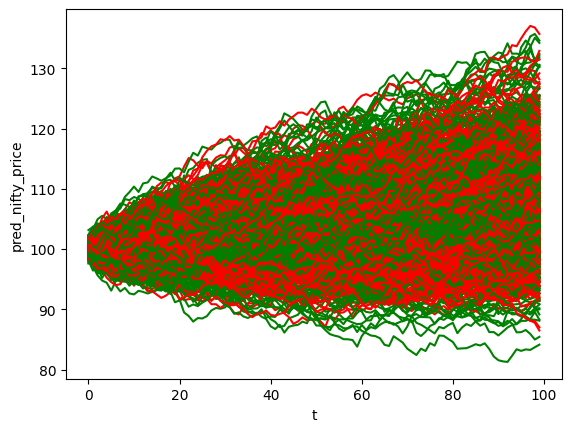

In [ ]:
for df in generated_price_list:
    sns.lineplot(x = 't', y = 'pred_nifty_price', data = df, color = 'red')
    sns.lineplot(x = 't', y = 'pred_gold_price', data = df, color = 'green')



In [ ]:
nifty_samples = pd.DataFrame({f's_{idx + 1:03}' : df['pred_nifty_price'] for idx, df in enumerate(generated_price_list)})
gold_samples = pd.DataFrame({f's_{idx + 1:03}' : df['pred_gold_price'] for idx, df in enumerate(generated_price_list)})

In [ ]:
nifty_samples.index = [f'day_{idx + 1:03}' for idx, _ in enumerate(nifty_samples.index)]
gold_samples.index = [f'day_{idx + 1:03}' for idx, _ in enumerate(gold_samples.index)]

<Axes: >

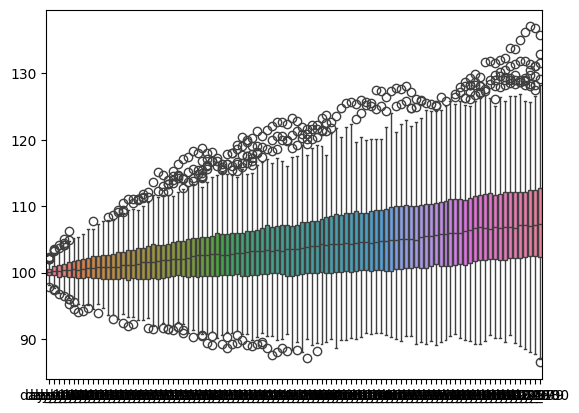

In [ ]:
sns.boxplot(nifty_samples.T)